In [ ]:
!pip install --upgrade torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import copy

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Veri setinin hazırlanması
root_dir = '/content/drive/MyDrive/CustomDRDataset/train'  # Görsellerin bulunduğu ana klasör
full_dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)

In [ ]:
# Eğitim ve doğrulama setlerini ayırma (%80 - %20 oranında)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Doğrulama veri setine farklı dönüşüm uygulama
val_dataset.dataset.transform = val_transforms

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Sınıf isimleri
class_names = full_dataset.classes
print("Sınıflar (klasör adları):", class_names)
print("Eğitim veri sayısı:", dataset_sizes['train'])
print("Doğrulama veri sayısı:", dataset_sizes['val'])

Sınıflar (klasör adları): ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Eğitim veri sayısı: 10164
Doğrulama veri sayısı: 2541


In [ ]:
# Cihaz ayarı
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda:0


In [ ]:
# EfficientNet-B5 modelini yükleme (önceden eğitilmiş ağırlıklar)
model_ft = models.efficientnet_b5(pretrained=True)
# Final classifier katmanını veri setinizin sınıf sayısına göre uyarlayın.
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Kayıp fonksiyonu, optimizer ve öğrenme hızı scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Eğitim döngüsü
num_epochs = 25
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer_ft.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())

    exp_lr_scheduler.step()
    print()

print('Eğitim tamamlandı.')
print(f'En iyi doğrulama doğruluğu: {best_acc:.4f}')
model_ft.load_state_dict(best_model_wts)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 154MB/s]


Epoch 1/25
--------------------
train Loss: 1.3184  Acc: 0.4711
val Loss: 1.0868  Acc: 0.5935

Epoch 2/25
--------------------
train Loss: 0.9481  Acc: 0.6332
val Loss: 0.8100  Acc: 0.7009

Epoch 3/25
--------------------
train Loss: 0.7597  Acc: 0.7074
val Loss: 0.6443  Acc: 0.7627

Epoch 4/25
--------------------
train Loss: 0.6210  Acc: 0.7680
val Loss: 0.5148  Acc: 0.8300

Epoch 5/25
--------------------
train Loss: 0.4994  Acc: 0.8258
val Loss: 0.4134  Acc: 0.8686

Epoch 6/25
--------------------
train Loss: 0.3838  Acc: 0.8700
val Loss: 0.3227  Acc: 0.9000

Epoch 7/25
--------------------
train Loss: 0.3022  Acc: 0.9015
val Loss: 0.2566  Acc: 0.9260

Epoch 8/25
--------------------
train Loss: 0.2515  Acc: 0.9216
val Loss: 0.2451  Acc: 0.9335

Epoch 9/25
--------------------
train Loss: 0.2388  Acc: 0.9264
val Loss: 0.2388  Acc: 0.9355

Epoch 10/25
--------------------
train Loss: 0.2251  Acc: 0.9295
val Loss: 0.2310  Acc: 0.9386

Epoch 11/25
--------------------
train Loss: 0.22

<All keys matched successfully>

In [ ]:
# Modeli kaydetme
model_save_path = '/content/drive/MyDrive/CustomDRDataset/efficientnetb5_finetuned.pth'
torch.save(model_ft.state_dict(), model_save_path)
print("Model PyTorch formatında kaydedildi:", model_save_path)

Model PyTorch formatında kaydedildi: /content/drive/MyDrive/CustomDRDataset/efficientnetb5_finetuned.pth


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Model dosyasının yolu (kendi yolunuzu kullanın)
model_path = '/content/drive/MyDrive/CustomDRDataset/efficientnetb5_finetuned.pth'

# Sınıf isimleri (örneğin, eğitim sırasında belirlediğiniz)
class_names = ['Mild', 'Moderate', 'NO_DR', 'Proliferate_DR', 'Severe']

# Cihaz ayarı
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modeli tanımlayın (eğitim sırasında kullandığınız yapı ile aynı)
model_ft = models.efficientnet_b5(pretrained=False)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Eğitilmiş ağırlıkları yükleyin ve modeli cihazınıza taşıyın
model_ft.load_state_dict(torch.load(model_path, map_location=device))
model_ft = model_ft.to(device)
model_ft.eval()

print("Model başarıyla yüklendi ve inference için hazır.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-2-d7ba21ae7790>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Model başarıyla yüklendi ve inference için hazır.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bAuwrR.png to bAuwrR.png


In [ ]:
# Test için dönüşümler (doğrulama aşamasındakiyle aynı)
import PIL
from torchvision import transforms
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

for filename in uploaded.keys():
    image = PIL.Image.open(filename).convert('RGB')
    input_tensor = test_transforms(image)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model_ft(input_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]
    print(f"Yüklenen dosya: {filename}")
    print(f"Tahmin edilen sınıf: {predicted_class}")

Yüklenen dosya: bAuwrR.png
Tahmin edilen sınıf: Proliferate_DR


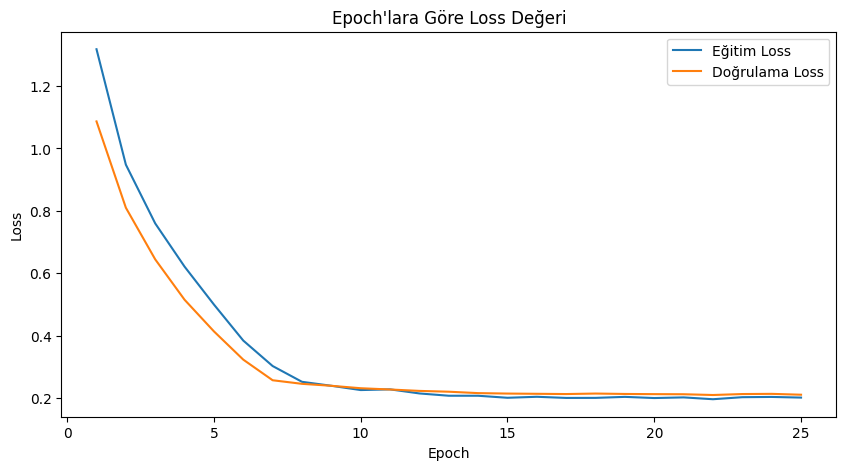

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Eğitim Loss')
plt.plot(epochs, val_losses, label='Doğrulama Loss')
plt.title('Epoch\'lara Göre Loss Değeri')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


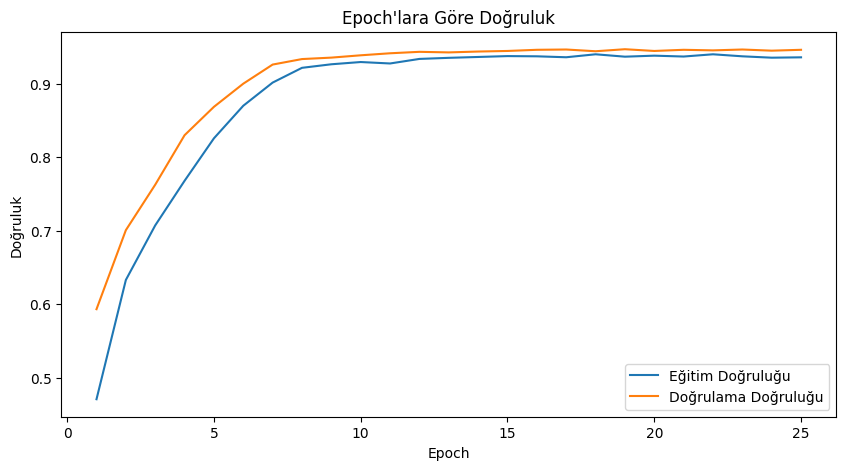

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracies, label='Doğrulama Doğruluğu')
plt.title('Epoch\'lara Göre Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Tüm validasyon verisini değerlendirip gerçek ve tahmin edilen etiketleri alalım
all_preds = []
all_labels = []

model_ft.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[495   0   4   0   0]
 [ 26 422  19  24  18]
 [ 22   7 489   2   0]
 [  2   6   0 493   1]
 [  0   0   0   4 507]]


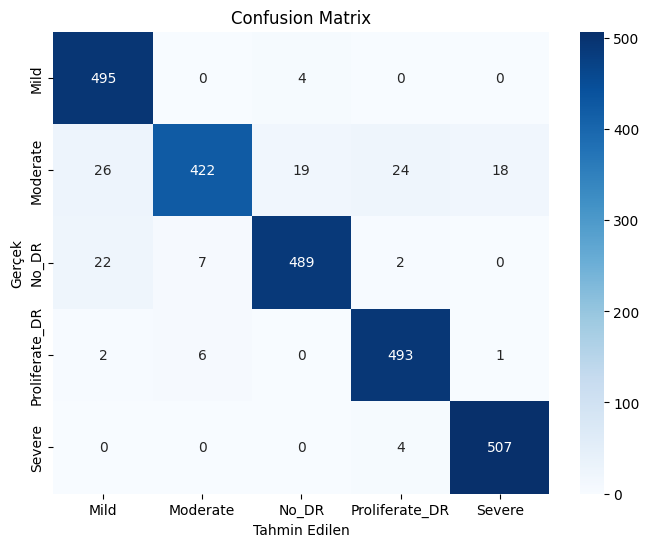

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch.nn.functional as F

all_probs = []
all_labels = []

model_ft.eval()  # model tahmin moduna alınır
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_ft(inputs)
        probs = F.softmax(outputs, dim=1)  # Softmax uygulanır
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

import numpy as np
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)


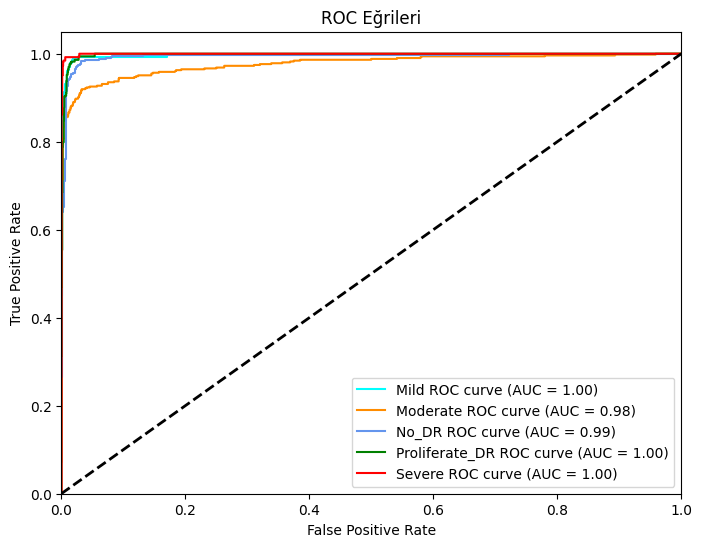

In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Gerçek etiketler ve model tahminleri (olasılık değerleri) üzerinde çalıştığınızı varsayalım:
# all_labels: gerçek etiketler, all_probs: her sınıf için model çıktısı (softmax sonrası olasılık)
# Örnek: all_labels = [0,1,2,...] ve all_probs.shape = (n_samples, n_classes)
n_classes = len(class_names)
all_labels_bin = label_binarize(all_labels, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{class_names[i]} ROC curve (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc="lower right")
plt.show()


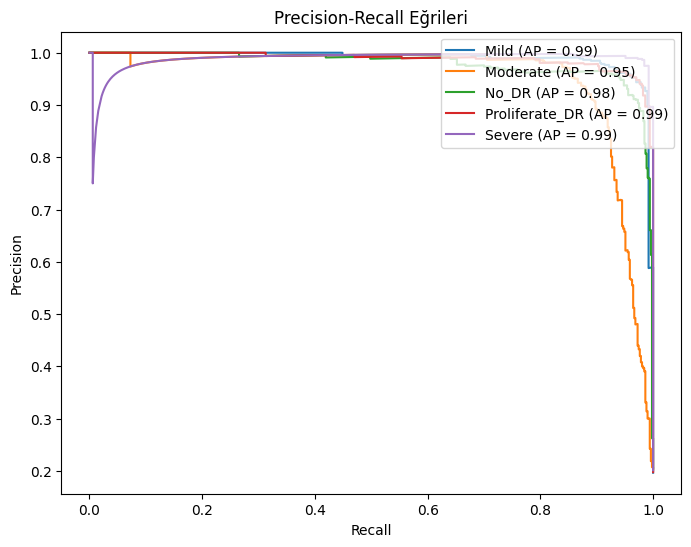

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
    avg_precision = average_precision_score(all_labels_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {avg_precision:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Eğrileri')
plt.legend(loc='upper right')
plt.show()


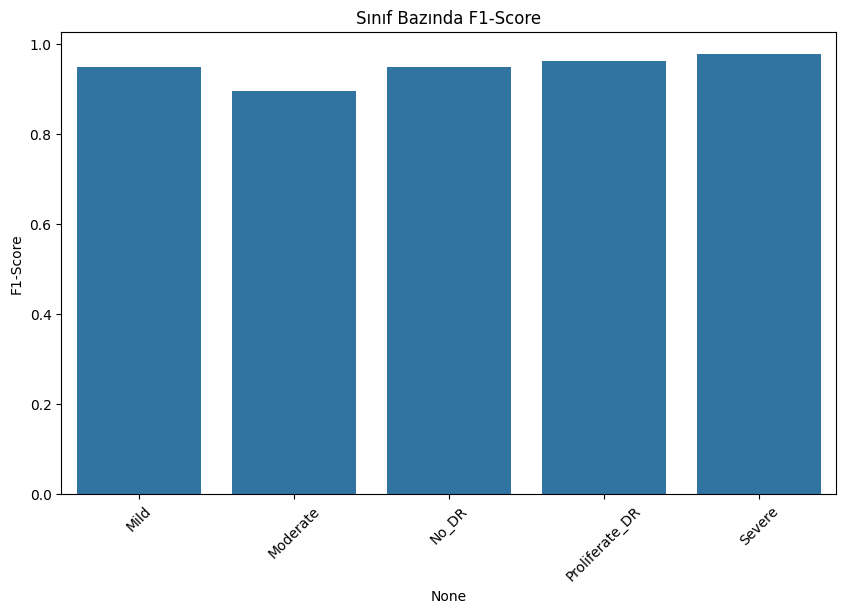

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# classification_report çıktısını pandas DataFrame'e çevirip görselleştirebilirsiniz
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.barplot(x=df_report.index[:-3], y=df_report['f1-score'][:-3])
plt.ylabel('F1-Score')
plt.title('Sınıf Bazında F1-Score')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Model mimarisini yeniden tanımlayın (eğitim sırasında kullandığınız yapı ile aynı olmalı)
model_ft = models.efficientnet_b5(pretrained=False)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 5)

# Eğitilmiş ağırlıkları yükleyin
model_path = "/content/drive/MyDrive/CustomDRDataset/efficientnetb5_finetuned.pth"
model_ft.load_state_dict(torch.load(model_path, map_location="cpu"))
model_ft.eval()

# Modeli TorchScript'e dönüştürün
scripted_model = torch.jit.script(model_ft)
scripted_model_path = "/content/drive/MyDrive/efficientnetb5_finetuned_scripted.pt"
scripted_model.save(scripted_model_path)
print("TorchScript modeli kaydedildi:", scripted_model_path)


<ipython-input-5-b84ea4674815>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(model_path, map_location="cpu"))


TorchScript modeli kaydedildi: /content/drive/MyDrive/efficientnetb5_finetuned_scripted.pt
